<h1><center><font size="6">Final Lab: Transfer Learning with MobileNet and CIFAR-10</font></center></h1>

<img src="https://cdn-images-1.medium.com/max/800/1*QN007xhxgDTPBdNT0pnZ2g.png" width="400"></img>

# Main task

In this notebook, we will apply transfer learning techniques to finetune the [MobileNet](https://arxiv.org/pdf/1704.04861.pdf) CNN on [Cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

# Procedures

In general, the main steps that we will follow are:

- <a href='#1'>Load data, analyze and split in *training*/*validation*/*testing* sets</a>  
- <a href='#2'>Load CNN and analyze architecture</a>  
- <a href='#3'>Adapt this CNN to our problem</a>  
- <a href='#4'>Setup data augmentation techniques</a>
- <a href='#5'>Add some keras callbacks</a>   
- <a href='#6'>Setup optimization algorithm with their hyperparameters</a>  
- <a href='#7'>Train model!</a>
- <a href='#8'>Validation accuracy and loss</a>
- <a href='#9'>Choose best model/snapshot</a>
- <a href='#10'>Evaluate final model on the *testing* set</a>
- <a href='#11'>Conclusions</a>

# Students

* Maximiliano Armesto
* Martín Gonella

# Link to our DiploDatos Repo

* https://github.com/tyncho08/DiploDatos

---

In [1]:
# Setup one GPU for tensorflow (don't be greedy).
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# The GPU id to use, "0", "1", etc.
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #Select only one GPU 
# Use ---> watch -n 1 nvidia-smi (to see GPU use)

# https://keras.io/applications/#documentation-for-individual-models
from keras.applications.mobilenet import MobileNet
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras import optimizers
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import tensorflow as tf
from IPython.display import SVG
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
%matplotlib inline

# Limit tensorflow gpu usage.
# Maybe you should comment this lines if you run tensorflow on CPU.
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.6 #Memory use on GPU
sess = tf.Session(config=config)

Using TensorFlow backend.


---

# <a id="1">Load data, analyze and split in *training*/*validation*/*testing* sets</a>  

In [2]:
# Cifar-10 class names
# We will create a dictionary for each type of label
# This is a mapping from the int class name to 
# their corresponding string class name
LABELS = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

############
# Load dataset from keras
(x_train_data, y_train_data), (x_test_data, y_test_data) = cifar10.load_data()
############

############ 
# Some prints to see the loaded data dimensions
############
print("CIFAR-10 x_train shape: {}".format(x_train_data.shape))
print("CIFAR-10 y_train shape: {}".format(y_train_data.shape))
print("CIFAR-10 x_test shape: {}".format(x_test_data.shape))
print("CIFAR-10 y_test shape: {}".format(y_test_data.shape))

CIFAR-10 x_train shape: (50000, 32, 32, 3)
CIFAR-10 y_train shape: (50000, 1)
CIFAR-10 x_test shape: (10000, 32, 32, 3)
CIFAR-10 y_test shape: (10000, 1)


In [3]:
############ 
# Some constants
############ 
IMG_ROWS = 128
IMG_COLS = 128
NUM_CLASSES = 10
TEST_SIZE = 0.2
RANDOM_STATE = 2018

############ 
#Model
############ 
NO_EPOCHS = 50
BATCH_SIZE = 32

############ 
#Experiment Number
############ 
EXP_ID = 'logs/experiment_000/'

### Class distribution: Train set images 

We analyze the amount of images for each class and plot some images to explore how they look

In [4]:
def get_classes_distribution(y_data):
    # Get the count for each label
    y = np.bincount(y_data)
    ii = np.nonzero(y)[0]
    label_counts = zip(ii, y[ii])

    # Get total number of samples
    total_samples = len(y_data)

    # Count the number of items in each class
    for label, count in label_counts:
        class_name = LABELS[label]
        percent = (count / total_samples) * 100
        print("{:<15s}:  {} or {:.2f}%".format(class_name, count, percent))
        
    return label_counts

train_label_counts = get_classes_distribution(np.reshape(y_train_data, len(y_train_data)))

airplane       :  5000 or 10.00%
automobile     :  5000 or 10.00%
bird           :  5000 or 10.00%
cat            :  5000 or 10.00%
deer           :  5000 or 10.00%
dog            :  5000 or 10.00%
frog           :  5000 or 10.00%
horse          :  5000 or 10.00%
ship           :  5000 or 10.00%
truck          :  5000 or 10.00%


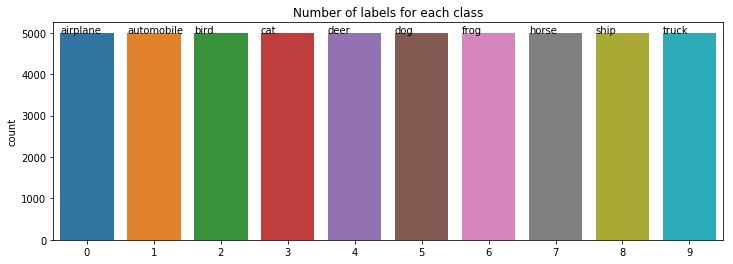

In [5]:
def plot_label_per_class(y_data):
    
    classes = sorted(np.unique(y_data))
    f, ax = plt.subplots(1,1, figsize=(12, 4))
    g = sns.countplot(y_data, order=classes)
    g.set_title("Number of labels for each class")
    
    for p, label in zip(g.patches, classes):
        g.annotate(LABELS[label], (p.get_x(), p.get_height() + 0.2))
    
    plt.show()
    
plot_label_per_class(np.reshape(y_train_data, len(y_train_data)))

### Class distribution: Test set images 

In [6]:
get_classes_distribution(np.reshape(y_test_data, len(y_test_data)));

airplane       :  1000 or 10.00%
automobile     :  1000 or 10.00%
bird           :  1000 or 10.00%
cat            :  1000 or 10.00%
deer           :  1000 or 10.00%
dog            :  1000 or 10.00%
frog           :  1000 or 10.00%
horse          :  1000 or 10.00%
ship           :  1000 or 10.00%
truck          :  1000 or 10.00%


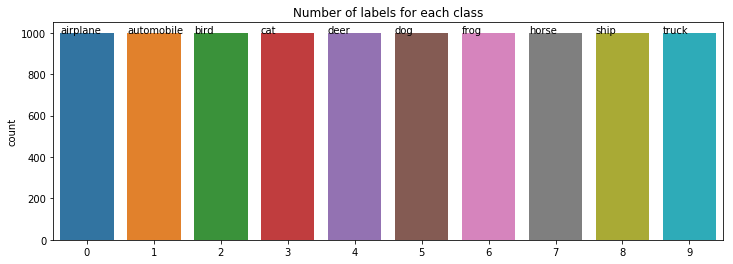

In [7]:
plot_label_per_class(np.reshape(y_test_data, len(y_test_data)))

### Images: Train set

Let's plot some samples for the images. We add labels to the train set images, with the corresponding CIFAR-10 item category. 

In [8]:
def sample_images_data(x_data, y_data):
    # An empty list to collect some samples
    sample_images = []
    sample_labels = []

    # Iterate over the keys of the labels dictionary defined in the above cell
    for k in LABELS.keys():
        # Get four samples for each category
        samples = np.where(y_data == k)[0][:4]
        # Append the samples to the samples list
        for s in samples:
            img = x_data[s]
            sample_images.append(img)
            sample_labels.append(y_data[s])

    print("Total number of sample images to plot: ", len(sample_images))
    return sample_images, sample_labels

train_sample_images, train_sample_labels = sample_images_data(x_train_data, y_train_data)

Total number of sample images to plot:  40


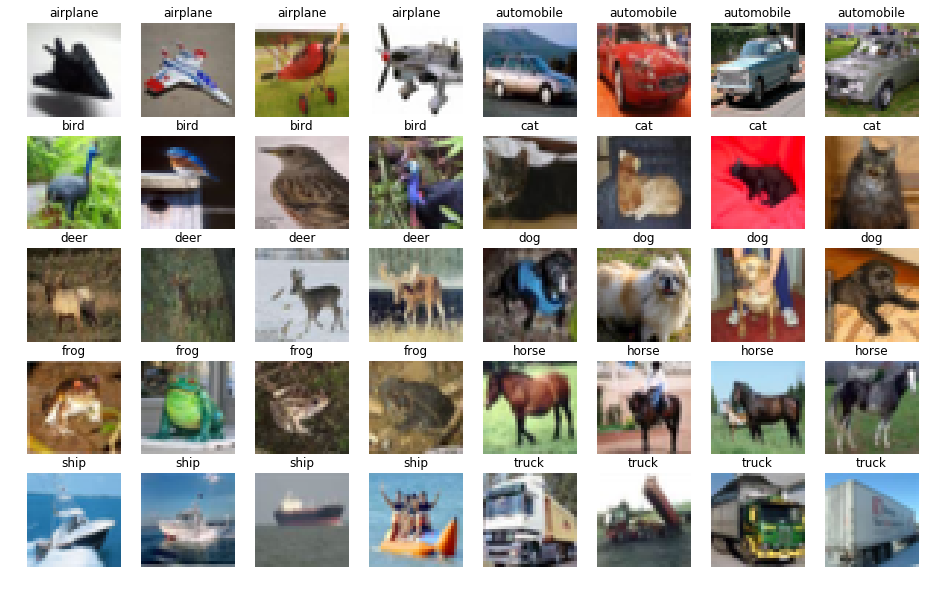

In [9]:
def plot_sample_images(data_sample_images, data_sample_labels, cmap="gray"):
    # Plot the sample images now
    f, ax = plt.subplots(5, 8, figsize=(16, 10))

    for i, img in enumerate(data_sample_images):
        ax[i//8, i%8].imshow(img, cmap=cmap)
        ax[i//8, i%8].axis('off')
        ax[i//8, i%8].set_title(LABELS[int(data_sample_labels[i])])
    plt.show()    
    
plot_sample_images(train_sample_images, train_sample_labels)

### Images: Test set

Total number of sample images to plot:  40


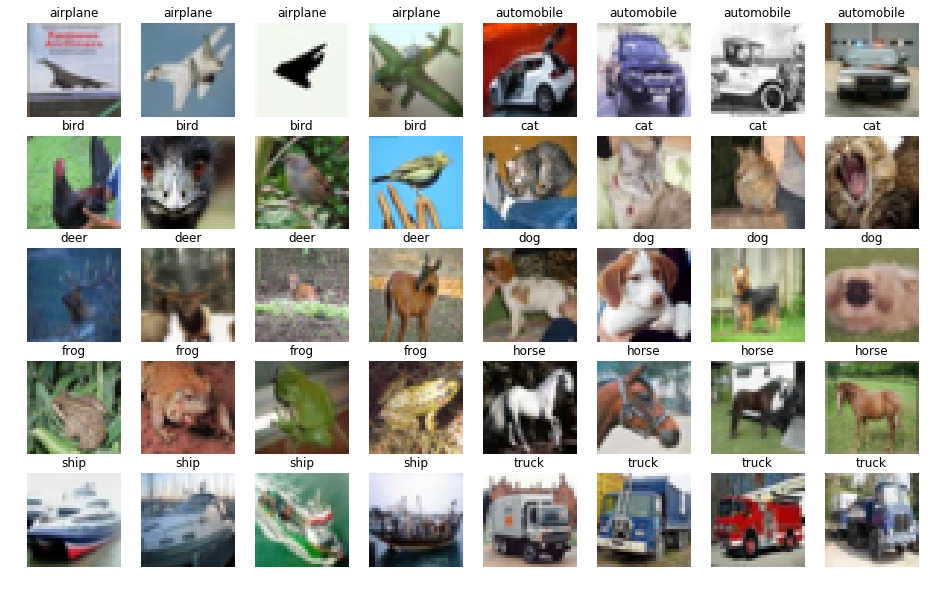

In [10]:
test_sample_images, test_sample_labels = sample_images_data(x_test_data, y_test_data)
plot_sample_images(test_sample_images, test_sample_labels)

### Data preprocessing

In this case, we only  perfom "to_categorical" conversion

In [11]:
def data_preprocessing(x_data, y_data):
    out_y = to_categorical(y_data, len(np.unique(y_data)))
    num_images = x_data.shape[0]
    #x_shaped_array = np.expand_dims(x_data, axis=-1)
    #out_x = x_shaped_array / 255.
    out_x = x_data
    
    return out_x, out_y

In [12]:
############
# Prepare the data
############
X, y = data_preprocessing(x_train_data, y_train_data)
X_test, y_test = data_preprocessing(x_test_data, y_test_data)

## Split train in train and validation set

We further split the train set in train and validation set. The validation set will be 20% from the original train set, therefore the split will be train/validation of 0.8/0.2.

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

print("CIFAR-10 X_train  -  rows: {}  columns: {}".format(X_train.shape[0], X_train.shape[1:4]))
print("CIFAR-10 X_valid  -  rows: {}  columns: {}".format(X_val.shape[0], X_val.shape[1:4]))
print("CIFAR-10 X_test   -  rows: {}  columns: {}".format(X_test.shape[0], X_test.shape[1:4]))
print("-----------------------------------------------------------")
print("CIFAR-10 y_train  -  rows: {}  columns: {}".format(y_train.shape[0], y_train.shape[1]))
print("CIFAR-10 y_valid  -  rows: {}  columns: {}".format(y_val.shape[0], y_val.shape[1]))
print("CIFAR-10 y_test   -  rows: {}  columns: {}".format(y_test.shape[0], y_test.shape[1]))

CIFAR-10 X_train  -  rows: 40000  columns: (32, 32, 3)
CIFAR-10 X_valid  -  rows: 10000  columns: (32, 32, 3)
CIFAR-10 X_test   -  rows: 10000  columns: (32, 32, 3)
-----------------------------------------------------------
CIFAR-10 y_train  -  rows: 40000  columns: 10
CIFAR-10 y_valid  -  rows: 10000  columns: 10
CIFAR-10 y_test   -  rows: 10000  columns: 10


airplane       :  4030 or 10.08%
automobile     :  4028 or 10.07%
bird           :  3990 or 9.98%
cat            :  3992 or 9.98%
deer           :  4010 or 10.03%
dog            :  4022 or 10.05%
frog           :  4002 or 10.01%
horse          :  3978 or 9.95%
ship           :  3972 or 9.93%
truck          :  3976 or 9.94%


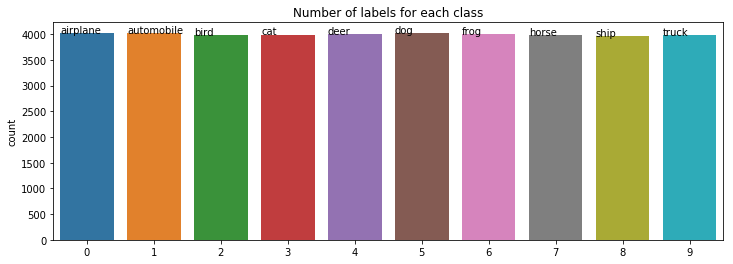

In [14]:
get_classes_distribution(np.argmax(y_train, axis=1))
plot_label_per_class(np.argmax(y_train, axis=1))

airplane       :  970 or 9.70%
automobile     :  972 or 9.72%
bird           :  1010 or 10.10%
cat            :  1008 or 10.08%
deer           :  990 or 9.90%
dog            :  978 or 9.78%
frog           :  998 or 9.98%
horse          :  1022 or 10.22%
ship           :  1028 or 10.28%
truck          :  1024 or 10.24%


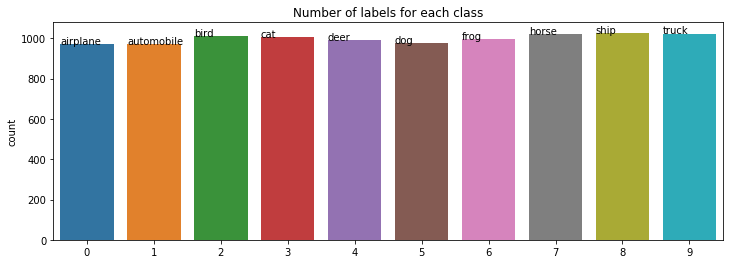

In [15]:
get_classes_distribution(np.argmax(y_val, axis=1))
plot_label_per_class(np.argmax(y_val, axis=1))

In [16]:
############
# Save the dataset to disk
############

def save_to_disk(x_data, y_data, usage, output_dir='cifar10_images'):
    """    
    x_data : np.ndarray
        Array with images.
    
    y_data : np.ndarray
        Array with labels.
    
    usage : str
        One of ['train', 'val', 'test'].

    output_dir : str
        Path to save data.
    """
    assert usage in ['train', 'val', 'test']
    
    # Set paths 
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for label in np.unique(np.argmax(y_data, axis=1)):
        label_path = os.path.join(output_dir, usage, str(label))
        if not os.path.exists(label_path):
            os.makedirs(label_path)
    
    for idx, img in enumerate(x_data):
        bgr_img = img[..., ::-1]  # RGB -> BGR
        label = np.argmax(y_data, axis=1)[idx]
        img_path = os.path.join(output_dir, usage, str(label), "img_{}.png".format(idx))
        
        retval = cv2.imwrite(r"%s"%(img_path), bgr_img)
        assert retval, 'Problem saving image at index: {}'.format(idx)

save_to_disk(X_train, y_train, 'train', 'cifar10_images')
save_to_disk(X_val,   y_val,   'val',   'cifar10_images')
save_to_disk(X_test,  y_test,  'test',  'cifar10_images')
print("All images saved!")

All images saved!


---

# <a id="2">Load CNN and analyze architecture</a> 

We use the __MobileNet__ class from Keras to load your base model, pre-trained on __imagenet__. We wan't to load the pre-trained weights, but without the classification layer.

In [17]:
base_model = MobileNet(input_shape=(IMG_ROWS, IMG_COLS, 3), # Input image sizealpha = 1,                           # default n° of filters from the paper are used at each layer.
                       weights='imagenet',                  # Use imagenet pre-trained weights
                       include_top=False,                   # Drop classification layer
                       pooling='avg')                       # Global AVG pooling for output feature vector

### Inspect the model

In [18]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

---

# <a id="3">Adapt this CNN to our problem</a> 

### We add some layers

Having the CNN loaded, now we have to add some layers to adapt this network to our classification problem. We can choose to finetune just the new added layers, some particular layers or all the layer of the model. 

In [19]:
############
# Get the output feature vector from the base model
############
x = base_model.output

############
# Let's add a fully-connected layer  with dropout
############
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

############
# Let's add a fully-connected layer with dropout
############
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

############
# Let's add a fully-connected layer  
############
x = Dense(512, activation='relu')(x)
#x = Dropout(0.4)(x)

############
# And a logistic layer
############
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

############
# This is the model we will train
############
model = Model(inputs=base_model.input, outputs=predictions)

In [20]:
############
# Check the final model
############
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

---

# <a id="4">Setup data augmentation techniques</a> 

We use data augmentation to train your model with the Keras ImageDataGenerator class for this porpouse.

Note that we have to resize our images to finetune the MobileNet CNN, this is done using the __target_size__ argument in flow_from_directory. We choose __target_size=(128,128)__.

In [21]:
############
# Training data generator
############
datagen_train = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip = False,
    rotation_range=10,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #featurewise_center=True,
    #samplewise_center=True,
    #featurewise_std_normalization=True,
    #samplewise_std_normalization=True,
    #zca_whitening=True
    )

train_generator = datagen_train.flow_from_directory(
        'cifar10_images/train',
        target_size=(IMG_ROWS,IMG_COLS),
        batch_size=BATCH_SIZE,
        color_mode='rgb')

############
# Validation data generator
############
datagen_val = ImageDataGenerator(
    rescale=1./255)

validation_generator = datagen_val.flow_from_directory(
        'cifar10_images/val',
        target_size=(IMG_ROWS,IMG_COLS),
        batch_size=BATCH_SIZE,
        color_mode='rgb')

Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


---

# <a id="5">We add some keras callbacks</a> 

* ModelCheckpoint
* EarlyStopping
* TensorBoard

In [22]:
if not os.path.exists(EXP_ID):
    os.makedirs(EXP_ID)

callbacks = [ModelCheckpoint(filepath=os.path.join(EXP_ID, 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'),
                    monitor='val_loss', 
                    verbose=1, 
                    save_best_only=False, 
                    save_weights_only=False, 
                    mode='auto'),
             EarlyStopping(monitor='val_loss', 
                  min_delta=0, 
                  patience=2, 
                  verbose=1, 
                  mode='auto', 
                  baseline=None),
             TensorBoard(log_dir=os.path.join(EXP_ID, 'logs'), 
                write_graph=True, 
                write_images=False)
]

If you have installed TensorFlow with pip, you should be able to launch TensorBoard from the command line:

```
tensorboard --logdir=/full_path_to_your_logs
```

---

# <a id="6">Setup optimization algorithm with their hyperparameters</a> 

In [23]:
############
#Choose one optimizer
############

optimizador = optimizers.SGD(lr=0.0001, momentum=0.9)
#optimizador = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
#optimizador = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
#optimizador = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
#optimizador = optimizers.Adam()
#optimizador = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizador,
              metrics=['accuracy'])

---

# <a id="7">Train model!</a> 

In [24]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1
3 conv1_bn
4 conv1_relu
5 conv_dw_1
6 conv_dw_1_bn
7 conv_dw_1_relu
8 conv_pw_1
9 conv_pw_1_bn
10 conv_pw_1_relu
11 conv_pad_2
12 conv_dw_2
13 conv_dw_2_bn
14 conv_dw_2_relu
15 conv_pw_2
16 conv_pw_2_bn
17 conv_pw_2_relu
18 conv_dw_3
19 conv_dw_3_bn
20 conv_dw_3_relu
21 conv_pw_3
22 conv_pw_3_bn
23 conv_pw_3_relu
24 conv_pad_4
25 conv_dw_4
26 conv_dw_4_bn
27 conv_dw_4_relu
28 conv_pw_4
29 conv_pw_4_bn
30 conv_pw_4_relu
31 conv_dw_5
32 conv_dw_5_bn
33 conv_dw_5_relu
34 conv_pw_5
35 conv_pw_5_bn
36 conv_pw_5_relu
37 conv_pad_6
38 conv_dw_6
39 conv_dw_6_bn
40 conv_dw_6_relu
41 conv_pw_6
42 conv_pw_6_bn
43 conv_pw_6_relu
44 conv_dw_7
45 conv_dw_7_bn
46 conv_dw_7_relu
47 conv_pw_7
48 conv_pw_7_bn
49 conv_pw_7_relu
50 conv_dw_8
51 conv_dw_8_bn
52 conv_dw_8_relu
53 conv_pw_8
54 conv_pw_8_bn
55 conv_pw_8_relu
56 conv_dw_9
57 conv_dw_9_bn
58 conv_dw_9_relu
59 conv_pw_9
60 conv_pw_9_bn
61 conv_pw_9_relu
62 conv_dw_10
63 conv_dw_10_bn
64 conv_dw_10_relu
65 conv_pw_10

In [25]:
############
# We select the trainable layers
############

'''for layer in model.layers[:60]:
    layer.trainable = False
for layer in model.layers[60:]:
    layer.trainable = True'''
    
for layer in model.layers:
    layer.trainable = True    

In [26]:
train_model = model.fit_generator(
        generator=train_generator,
        epochs=NO_EPOCHS,
        verbose=1,
        validation_data=validation_generator,
        steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
        validation_steps=X_val.shape[0] // BATCH_SIZE,
        callbacks=callbacks)

Epoch 1/50
1250/1250 [==============================] - 185s 148ms/step - loss: 1.9258 - acc: 0.3223 - val_loss: 1.0584 - val_acc: 0.6665

Epoch 00001: saving model to logs/experiment_000/weights.01-1.06.hdf5
Epoch 2/50
1250/1250 [==============================] - 165s 132ms/step - loss: 1.0828 - acc: 0.6177 - val_loss: 0.6591 - val_acc: 0.7702

Epoch 00002: saving model to logs/experiment_000/weights.02-0.66.hdf5
Epoch 3/50
1250/1250 [==============================] - 165s 132ms/step - loss: 0.7937 - acc: 0.7223 - val_loss: 0.4874 - val_acc: 0.8337

Epoch 00003: saving model to logs/experiment_000/weights.03-0.49.hdf5
Epoch 4/50
1250/1250 [==============================] - 166s 133ms/step - loss: 0.6491 - acc: 0.7744 - val_loss: 0.4081 - val_acc: 0.8585

Epoch 00004: saving model to logs/experiment_000/weights.04-0.41.hdf5
Epoch 5/50
1250/1250 [==============================] - 164s 131ms/step - loss: 0.5549 - acc: 0.8101 - val_loss: 0.3563 - val_acc: 0.8789

Epoch 00005: saving model

1250/1250 [==============================] - 164s 132ms/step - loss: 0.1197 - acc: 0.9589 - val_loss: 0.1424 - val_acc: 0.9529

Epoch 00040: saving model to logs/experiment_000/weights.40-0.14.hdf5
Epoch 41/50
1250/1250 [==============================] - 165s 132ms/step - loss: 0.1137 - acc: 0.9610 - val_loss: 0.1451 - val_acc: 0.9532

Epoch 00041: saving model to logs/experiment_000/weights.41-0.15.hdf5
Epoch 42/50
1250/1250 [==============================] - 163s 130ms/step - loss: 0.1163 - acc: 0.9599 - val_loss: 0.1462 - val_acc: 0.9536

Epoch 00042: saving model to logs/experiment_000/weights.42-0.15.hdf5
Epoch 00042: early stopping


---

# <a id="8">Validation accuracy and loss</a> 

Let's plot the train and validation accuracy and loss, from the training history.

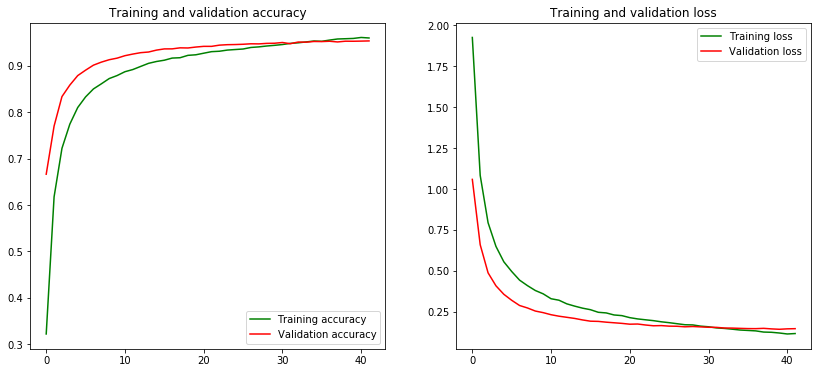

In [27]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['acc']
    val_acc = hist['val_acc']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()

plot_accuracy_and_loss(train_model)

---

# <a id="9">Choose best model/snapshot</a> 

* As we used __EarlyStopping__, it was the same callback that was in charge of stopping the training from the point from which there was no improvement in the __val_loss__. The __EarlyStopping__ stopped the training process in the epoch=42.

* Several models were tested, which we did not include for a better clarity, however all were overfitted.

* We had to retrain all the layers: __MobileNet__ and the added ones to avoid overfitting.

* The best results were obtained with an SGD optimizer with LR = 0.0001.

* A strategy of data augmentation not so aggressive was used, since the more aggressive, the more overfitting.

---

# <a id="10">Evaluate final model on the *testing* set</a> 

In [29]:
############
# Validation data generator
############

datagen_test = ImageDataGenerator(
    rescale=1./255)

test_generator = datagen_test.flow_from_directory(
        'cifar10_images/test',
        target_size=(IMG_ROWS,IMG_COLS),
        batch_size=BATCH_SIZE,
        color_mode='rgb')

score = model.evaluate_generator(test_generator, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Found 10000 images belonging to 10 classes.
Test loss: 0.16461974517144262
Test accuracy: 0.9469


---

# <a id="11">Conclusions</a> 

* We tested several models only by training the layers added by us, keeping the original __MobileNet__ layers unchanged; In all these cases, the model was overfitted at a few epochs.

* As we trained more layers of the __MobileNet__, the overfitting decreased. So we decided to retrain all the __MobileNet__ layers, plus the added layers.

* The images of CIFAR-10, were too small (32x32), so the expansion to the size of __MobileNet__ (128x128) introduced several problems that were reflected in the training process.

* The analysis of the precision and loss curves proved to be very useful and allowed to detect the overfitting.

* We achieved a test accuracy of 94.69%

### We only include the model with the best performance and we do not upload the dataset, due to the size of the files.